In [1]:
from CommonImports import *
np.set_printoptions(threshold=sys.maxsize)
#%matplotlib notebook

# GPS Data

In [2]:
#get data
df = pd.read_csv('loon-flights-2021Q1.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6443882 entries, 0 to 6443881
Data columns (total 18 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   flight_id               object 
 1   time                    object 
 2   latitude                float64
 3   longitude               float64
 4   altitude                float64
 5   temperature             float64
 6   pressure                float64
 7   earth_ir                float64
 8   earth_ir_sensor_config  int64  
 9   acs                     int64  
 10  propeller_on            int64  
 11  velocity_u              float64
 12  velocity_v              float64
 13  omega                   float64
 14  acceleration            float64
 15  solar_elevation         float64
 16  solar_azimuth           float64
 17  is_daytime              int64  
dtypes: float64(12), int64(4), object(2)
memory usage: 884.9+ MB


### Clean Data

In [3]:
df= df[df['acs'] == 0] #only keep entries with acs = 0 
df= df[df['altitude'].notnull()] #want to keep entries of balloons in the air

In [4]:
#now only keep temperature, altitude, longitude, latitude, time, and flight id
clmns = ['temperature', 'altitude', 'longitude', 'latitude', 'time', 'flight_id']
df = df[df.columns[df.columns.isin(clmns)]]
df.head()

flight_id                      time  latitude  longitude  altitude  \
57    LN-127  2021-01-01T00:46:52.000Z  3.762977 -76.406335   18300.0   
58    LN-127  2021-01-01T00:47:31.000Z  3.759985 -76.403821   18324.5   
59    LN-127  2021-01-01T00:47:52.000Z  3.758394 -76.402441   18315.0   
60    LN-127  2021-01-01T00:48:53.000Z  3.753812 -76.398384   18321.0   
61    LN-127  2021-01-01T00:49:53.000Z  3.749426 -76.394341   18323.2   

    temperature  
57       199.71  
58          NaN  
59       200.48  
60       200.07  
61       199.74

In [5]:
#before dropping NaN values convert the time column to datetime object
df['time_dt'] = pd.to_datetime(df['time'])
df.head()

flight_id                      time  latitude  longitude  altitude  \
57    LN-127  2021-01-01T00:46:52.000Z  3.762977 -76.406335   18300.0   
58    LN-127  2021-01-01T00:47:31.000Z  3.759985 -76.403821   18324.5   
59    LN-127  2021-01-01T00:47:52.000Z  3.758394 -76.402441   18315.0   
60    LN-127  2021-01-01T00:48:53.000Z  3.753812 -76.398384   18321.0   
61    LN-127  2021-01-01T00:49:53.000Z  3.749426 -76.394341   18323.2   

    temperature                   time_dt  
57       199.71 2021-01-01 00:46:52+00:00  
58          NaN 2021-01-01 00:47:31+00:00  
59       200.48 2021-01-01 00:47:52+00:00  
60       200.07 2021-01-01 00:48:53+00:00  
61       199.74 2021-01-01 00:49:53+00:00

In [6]:
#work with a smaller date range
start_date = '2021-01-01'
end_date = '2021-01-18'
df = df[(df['time_dt'] >= pd.to_datetime(start_date, utc=True)) & (df['time_dt'] <= pd.to_datetime(end_date, utc=True))]

In [7]:
#remove NaN temperature values 
df= df[df['temperature'].notnull()] #want to keep entries of balloons in the air
print(df['temperature'].isnull().sum())

0


In [8]:
#check how many flights are in date range 
allfltids = df['flight_id'].unique().tolist() #legend 
print(len(allfltids))

69


In [9]:
#check number of flight entries 
flt_filt = df.groupby(['flight_id']).agg({'time_dt':[np.min,np.max,'nunique']}).reset_index().rename(columns = {'amin':'start_time','amax':'end_time','nunique':'num_entries'})

#remove flights with low number of entries -- keep flights with over 20k entries
flt_filt = flt_filt[flt_filt["time_dt"]["num_entries"]>20000]

#check number of remaining flights to work with
allfltids = flt_filt['flight_id'].unique().tolist()
print(len(allfltids))

53


In [10]:
#keep only flights in allfltids
df = df[df['flight_id'].isin(allfltids)]

In [11]:
#check above worked -- don't need to run this cell 
check_fltids = df['flight_id'].unique().tolist()
print(len(check_fltids))

53


### Resample dataset so time indices match

In [12]:
#resample all of the flights -- we need to go flight by flight so we don't account for the jump between two different flights

#empty dataset
clmns = list(df.columns.values)
df_resamp = pd.DataFrame(columns=clmns)

for flt_id in allfltids: 
    df_temp = df[df['flight_id'] == flt_id]
    df_temp = df_temp.set_index('time_dt').resample('1T').ffill() #resample every 1 min -- set index removes time_dt as a column
    df_temp= df_temp[df_temp['flight_id'].notnull()] #get rid of 1st NaN value from resample
   
    #add new time idx back for later use
    time_idx = df_temp.index
    df_temp['time_dt'] = time_idx
    
    #concat to new dataframe
    df_resamp = pd.concat([df_resamp, df_temp], sort = False)

In [13]:
#reaggregate the resampled dataset 
flt_filt = df_resamp.groupby(['flight_id']).agg({'time_dt':[np.min,np.max,'nunique']}).reset_index().rename(columns = {'amin':'start_time','amax':'end_time','nunique':'num_entries'})

len(flt_filt['flight_id'].unique().tolist())

53

In [14]:
#find  min number of entries 
min_entries = flt_filt['time_dt']['num_entries'].min()
print(min_entries)

23384


In [15]:
#get flight associated with min entries -- use the start and end time to further filter the flights 
idx = flt_filt.index[flt_filt['time_dt']['num_entries'] == min_entries].tolist()
idx = idx[0]

In [16]:
#get start and end time 
flight = flt_filt.iloc[idx]
start_time = flight['time_dt']['start_time']
print(start_time)
end_time = flight['time_dt']['end_time']
print(end_time)

2021-01-01 00:01:00+00:00
2021-01-17 05:44:00+00:00


In [17]:
#need to truncate the df_resamp flight to stop at end_time 
df_resamp = df_resamp[(df_resamp['time_dt'] >= pd.to_datetime(start_time)) & (df_resamp['time_dt'] <= pd.to_datetime(end_time))]
df_resamp.head()

flight_id                      time  latitude  \
2021-01-01 00:01:00+00:00    LN-128  2021-01-01T00:00:49.000Z -4.019081   
2021-01-01 00:02:00+00:00    LN-128  2021-01-01T00:01:50.000Z -4.017329   
2021-01-01 00:03:00+00:00    LN-128  2021-01-01T00:02:50.000Z  -4.01566   
2021-01-01 00:04:00+00:00    LN-128  2021-01-01T00:03:50.000Z -4.013952   
2021-01-01 00:05:00+00:00    LN-128  2021-01-01T00:04:51.000Z -4.012111   

                           longitude altitude temperature  \
2021-01-01 00:01:00+00:00 -78.979806  18776.8      204.03   
2021-01-01 00:02:00+00:00 -78.983058  18779.1      204.52   
2021-01-01 00:03:00+00:00 -78.986056  18780.3       205.2   
2021-01-01 00:04:00+00:00 -78.989027  18775.4      205.28   
2021-01-01 00:05:00+00:00 -78.992135  18778.4      204.15   

                                             time_dt  
2021-01-01 00:01:00+00:00  2021-01-01 00:01:00+00:00  
2021-01-01 00:02:00+00:00  2021-01-01 00:02:00+00:00  
2021-01-01 00:03:00+00:00  2021-01-01 00:03:00+00:00  
2021-01-01 00:04:00+00:00  2021-01-01 00:04:00+00:00  
2021-01-01 00:05:00+00:00  2021-01-01 00:05:00+00:00

In [18]:
#check start and end time filtering worked 
flt_filt = df_resamp.groupby(['flight_id']).agg({'time_dt':[np.min,np.max,'nunique']}).reset_index().rename(columns = {'amin':'start_time','amax':'end_time','nunique':'num_entries'})

print(flt_filt['time_dt']['num_entries'])

0     23384
1     23384
2     23384
3     23384
4     23384
5     23379
6     23384
7     23384
8     23384
9     23384
10    23384
11    23348
12    23384
13    23306
14    23353
15    23384
16    23384
17    23384
18    23384
19    23381
20    23384
21    23384
22    23384
23    23384
24    23384
25    23384
26    23360
27    23384
28    23384
29    23362
30    23384
31    23384
32    23364
33    23359
34    23384
35    23349
36    23384
37    23384
38    23350
39    23384
40    23384
41    23384
42    23382
43    23384
44    23384
45    23357
46    23328
47    23384
48    23384
49    23383
50    23384
51    23384
52    23384
Name: num_entries, dtype: int64


In [19]:
#filter any flights that don't have the same number of entries 
flt_filt = flt_filt[flt_filt["time_dt"]["num_entries"] == min_entries]

print(flt_filt) 
#everything has the same start and end time so the next cell should run fine

   flight_id                    time_dt                                       
                             start_time                   end_time num_entries
0     LN-128  2021-01-01 00:01:00+00:00  2021-01-17 05:44:00+00:00       23384
1     LN-172  2021-01-01 00:01:00+00:00  2021-01-17 05:44:00+00:00       23384
2     LN-177  2021-01-01 00:01:00+00:00  2021-01-17 05:44:00+00:00       23384
3     LN-179  2021-01-01 00:01:00+00:00  2021-01-17 05:44:00+00:00       23384
4     LN-180  2021-01-01 00:01:00+00:00  2021-01-17 05:44:00+00:00       23384
6     LN-189  2021-01-01 00:01:00+00:00  2021-01-17 05:44:00+00:00       23384
7     LN-190  2021-01-01 00:01:00+00:00  2021-01-17 05:44:00+00:00       23384
8     LN-191  2021-01-01 00:01:00+00:00  2021-01-17 05:44:00+00:00       23384
9     LN-192  2021-01-01 00:01:00+00:00  2021-01-17 05:44:00+00:00       23384
10    LN-193  2021-01-01 00:01:00+00:00  2021-01-17 05:44:00+00:00       23384
12    LN-197  2021-01-01 00:01:00+00:00  2021-01-17 

In [20]:
#filter df_resamp 
flt_ids = flt_filt['flight_id'].unique().tolist()
df_resamp = df_resamp[df_resamp['flight_id'].isin(flt_ids)]

### Compute Distances

In [21]:
#now we can calculate distance 
#1) calculate greater circle distance
#2) use euclidean distance with ouput of haversince formula and difference in altitude to get distance between balloons

#greater circle distance using Haversine formula 
def HaversineDistance(lat1, lon1, lat2, lon2): 
    
    # The "Haversine formula" is used.
    D_Lo = lon2 - lon1 
    D_La = lat2 - lat1
    P = sin(D_La / 2)**2 + cos(lat1) * cos(lat2) * sin(D_Lo / 2)**2  

    Q = 2 * asin(sqrt(P))   
    R = 6371*1000  #earth's radius in m
    
    #calculate greater circle distance
    return (Q * R)
  

#compute distance 
def EuclidDist(coord_pair): 
    #index 0 = lat
    #index 1 = long
    #index 2 = alt
    
    lat1 = radians(coord_pair[0][0])  
    lon1 = radians(coord_pair[1][0]) 
    
    lat2 = radians(coord_pair[0][1])  
    lon2 = radians(coord_pair[1][1]) 
    
    alt1 = coord_pair[2][0]
    alt2 = coord_pair[2][1]
    
    return sqrt(HaversineDistance(lat1, lon1, lat2, lon2)**2 + (alt1 - alt2)**2)

In [22]:
N = len(flt_ids)
M = min_entries 
dist = np.zeros((M,N,N)) #TimexNodexNode matrix for storing distances (in meters)

#get upper triangle idx
indices = np.triu_indices_from(dist[0])
triu = zip(indices[0], indices[1])
idx_list = list(triu) #convert to list for looping

time_dt = df_resamp[df_resamp['flight_id'] == 'LN-172']['time_dt'] #time index
time_dt_test = time_dt[0:5]

tt = 0
start_time = time.time()
for t in time_dt:
    temp = df_resamp.loc[t] #current time stamp dataframe
    
    #get lat, long, and alt pairings 
    lat_list = list(itertools.combinations(temp['latitude'], 2))
    long_list = list(itertools.combinations(temp['longitude'], 2))
    alt_list = list(itertools.combinations(temp['altitude'], 2))
    
    coords = list(zip(lat_list, long_list, alt_list)) #create coordinate pairs between nodes
    ii = 0 #counter for looping through coordinate pairs, only increment if not on diagonal
    
    for idx in range(len(idx_list)):
        row, col = idx_list[idx]
        if row != col:
            #not on diagonal, compute distance 
            dist[tt][row][col] = round(EuclidDist(coords[ii]), 2)
            ii += 1 
            
        else: 
            #keep zero along diagonal 
            dist[tt][row][col] = 0
    
    tt += 1 #next time step 
    if tt % 2000 == 1999: 
        end_time = time.time()
        print(end_time - start_time)
        
end_time = time.time()
print(end_time - start_time)

18.72656798362732
35.7727746963501
51.33829641342163
66.78343081474304
79.24313759803772
90.06997084617615
101.7742190361023
112.12424993515015
124.35474371910095
136.66544461250305
149.130761384964
157.9099338054657


In [23]:
dist = dist + dist.transpose(0,2,1) #copy upper triangle to lower triangle

### Save Variables

In [24]:
#save variables to use for network data exploration 
np.save('distance_array.npy', dist)
df_resamp.to_csv('loon_data_filtered.csv', index=True)

In [25]:
t = time_dt[0]
temp = df_resamp.loc[t]

flight_pairs = list(itertools.combinations(temp['flight_id'],2))
np.save('flight_pairs.npy', flight_pairs)

In [26]:
flight_ids = list(temp['flight_id'])
np.save('flight_ids.npy', flight_ids)

In [27]:
time_dt.to_csv('time_dt.csv', index=True) #save using pandas since time_dt is pandas series

### Plot Distances vs. Time for All Node Pairs

Loop through all of the rows of the distance matrix and plot the distance between each balloon as a function of time. 

In [28]:
x_axis = time_dt

In [29]:
print(x_axis)

2021-01-01 00:01:00+00:00    2021-01-01 00:01:00+00:00
2021-01-01 00:02:00+00:00    2021-01-01 00:02:00+00:00
2021-01-01 00:03:00+00:00    2021-01-01 00:03:00+00:00
2021-01-01 00:04:00+00:00    2021-01-01 00:04:00+00:00
2021-01-01 00:05:00+00:00    2021-01-01 00:05:00+00:00
                                       ...            
2021-01-17 05:40:00+00:00    2021-01-17 05:40:00+00:00
2021-01-17 05:41:00+00:00    2021-01-17 05:41:00+00:00
2021-01-17 05:42:00+00:00    2021-01-17 05:42:00+00:00
2021-01-17 05:43:00+00:00    2021-01-17 05:43:00+00:00
2021-01-17 05:44:00+00:00    2021-01-17 05:44:00+00:00
Name: time_dt, Length: 23384, dtype: object


C:\Users\MA32162\AppData\Local\Temp\1\ipykernel_154612\3654791570.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


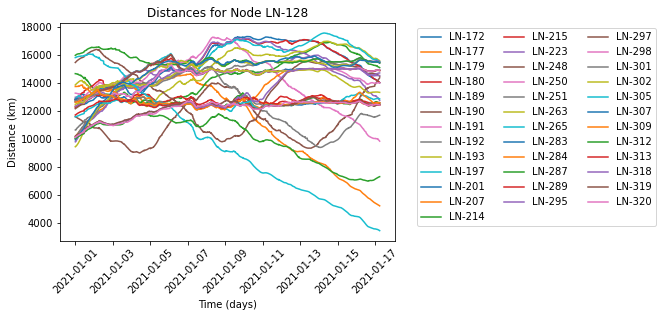

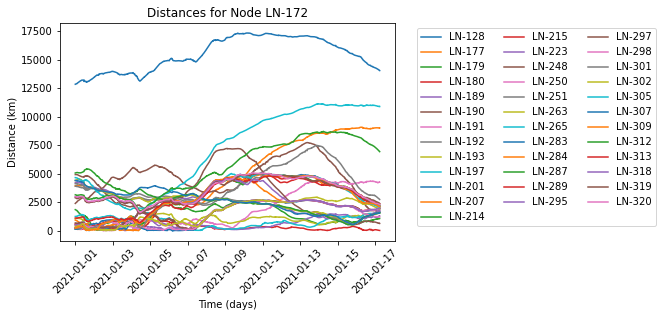

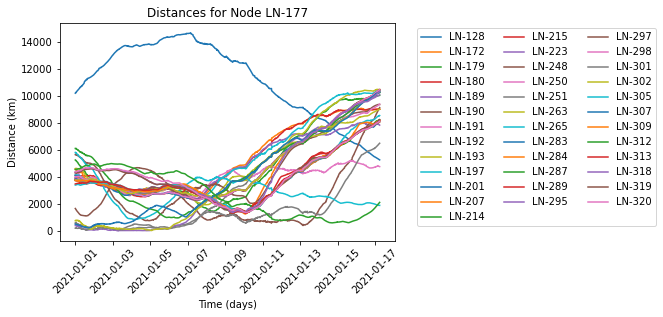

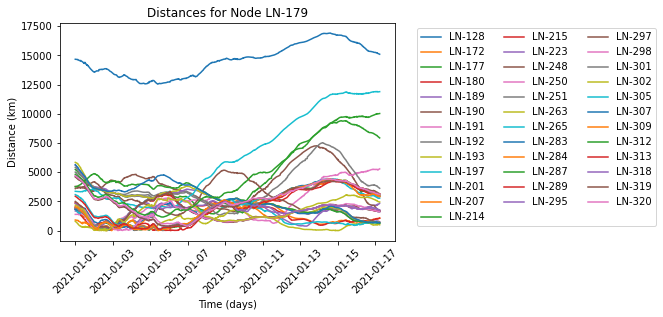

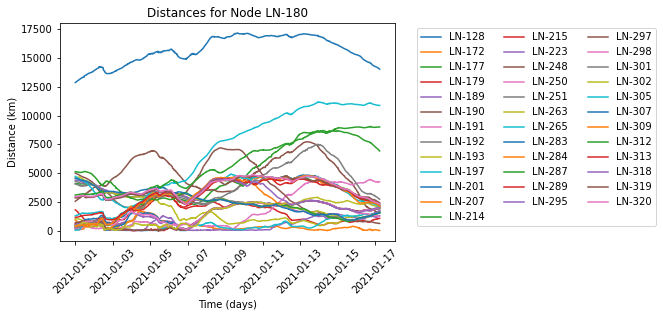

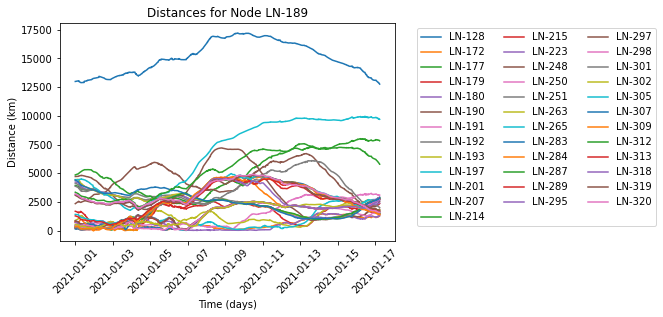

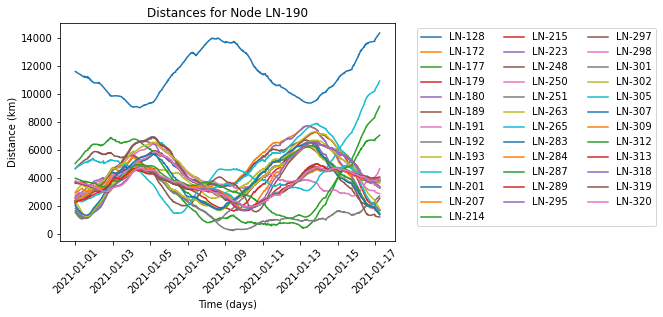

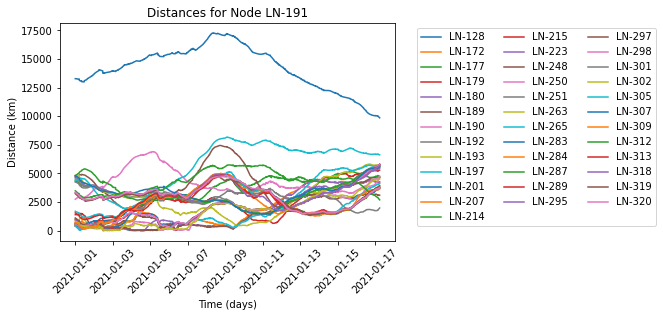

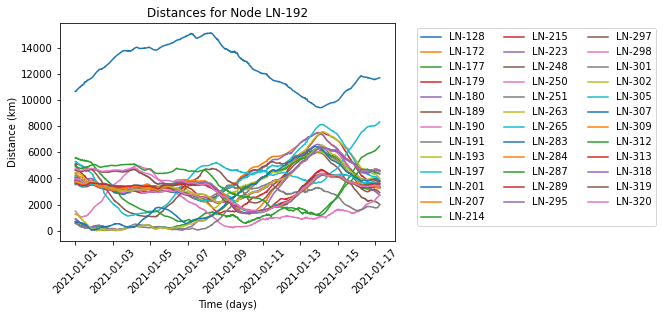

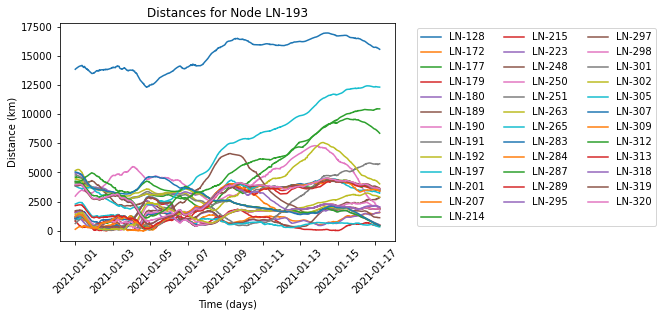

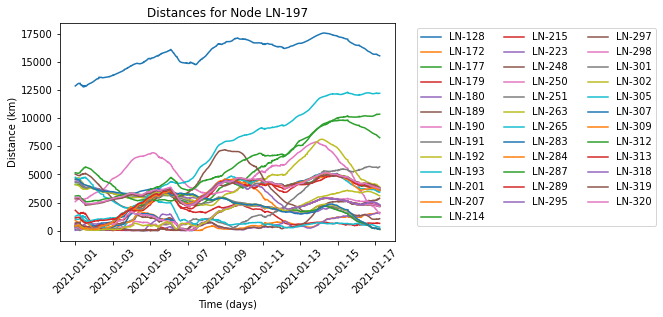

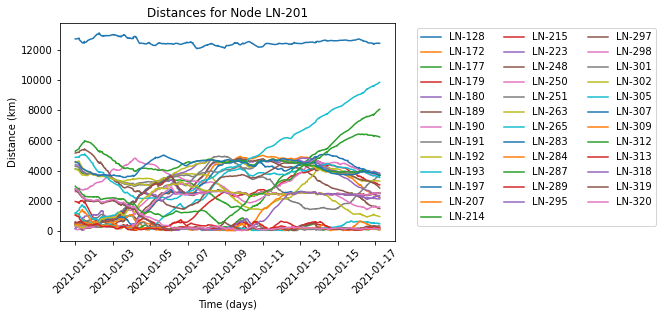

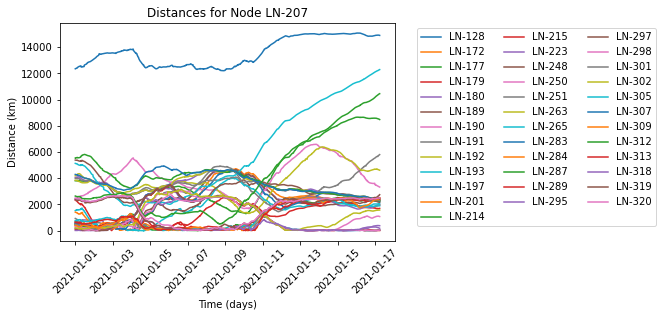

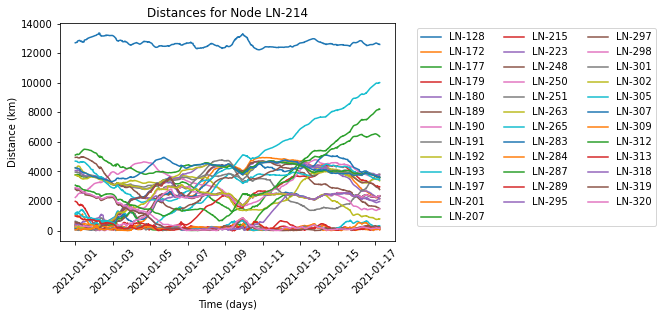

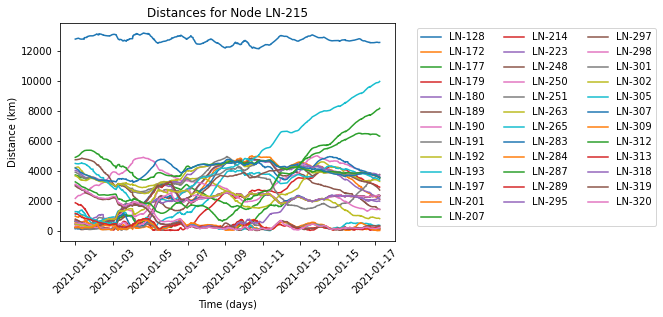

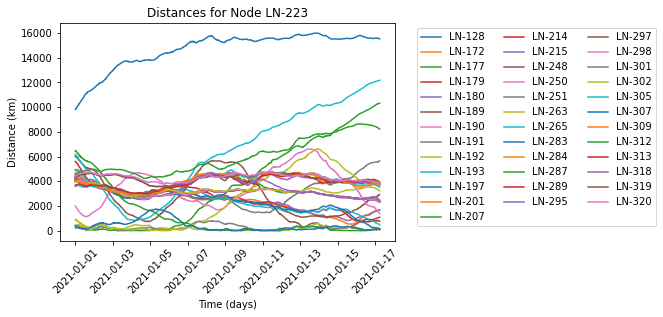

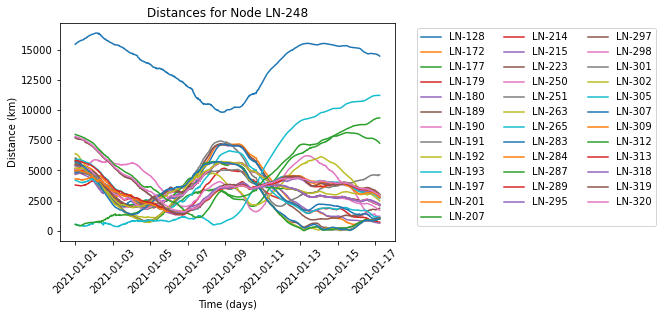

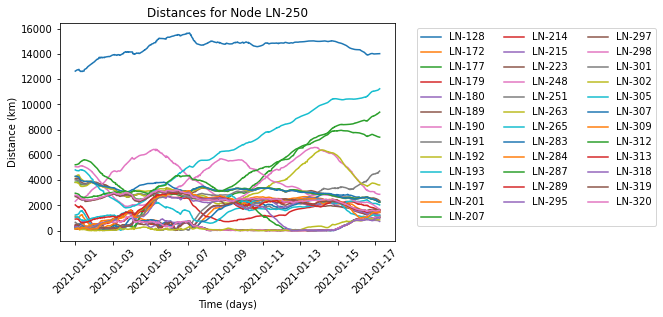

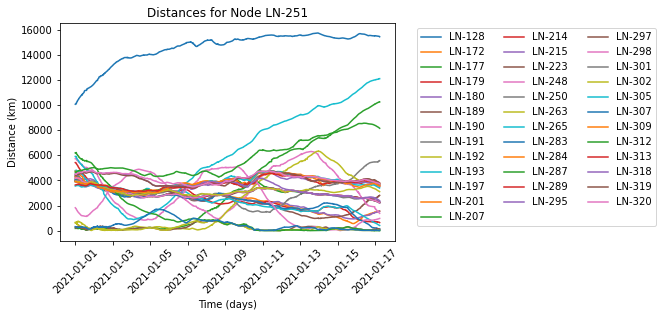

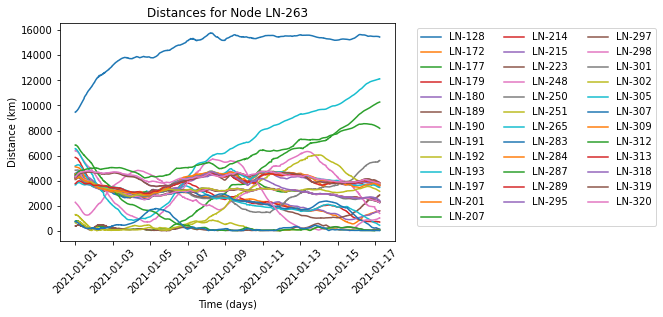

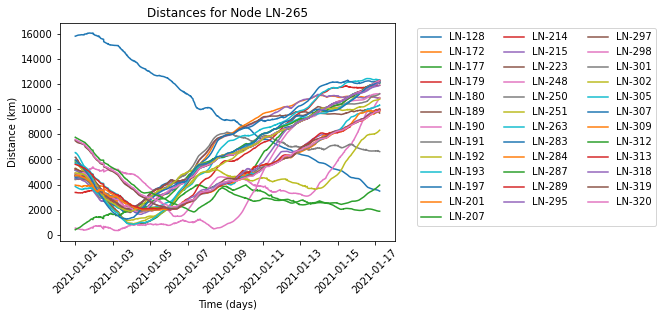

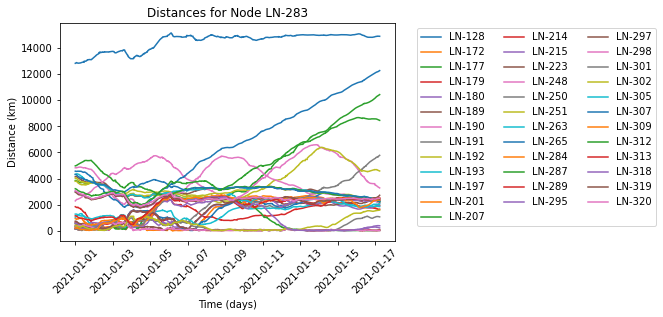

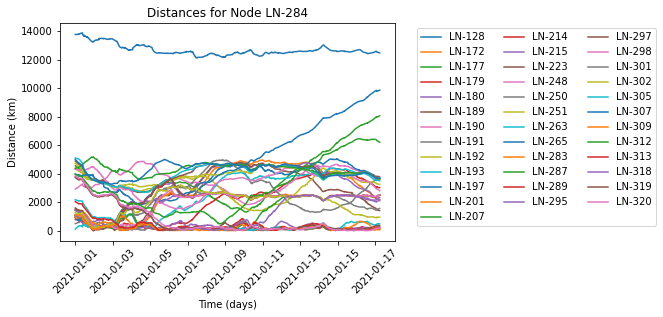

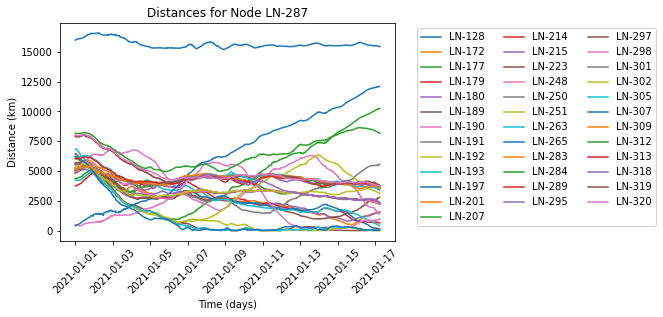

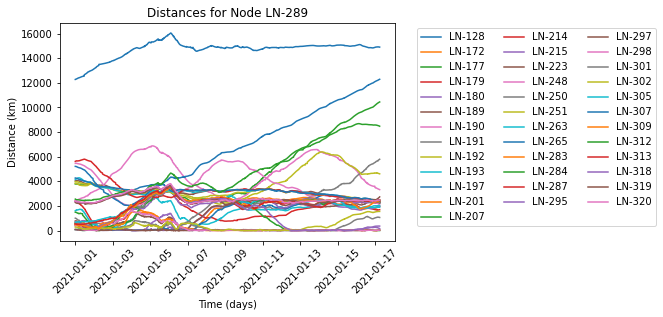

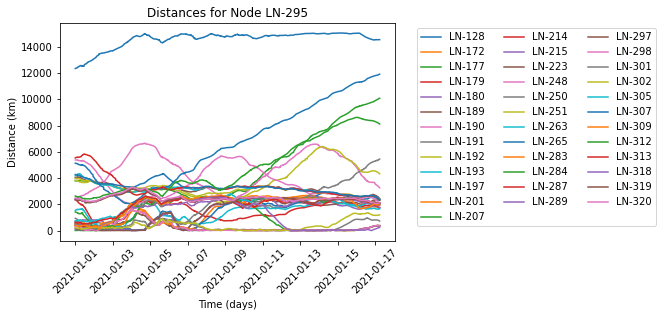

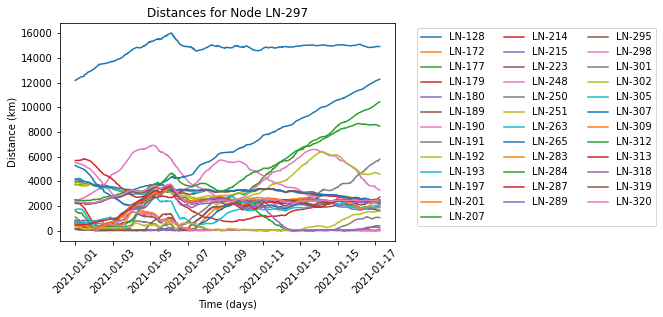

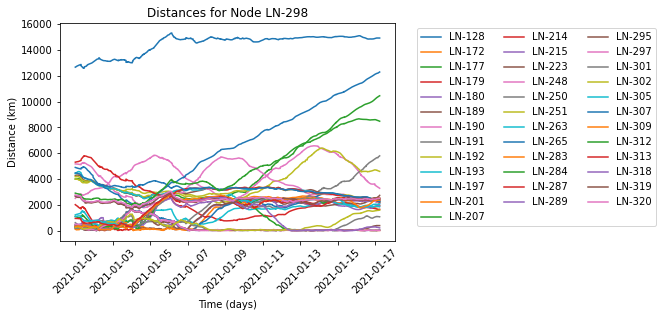

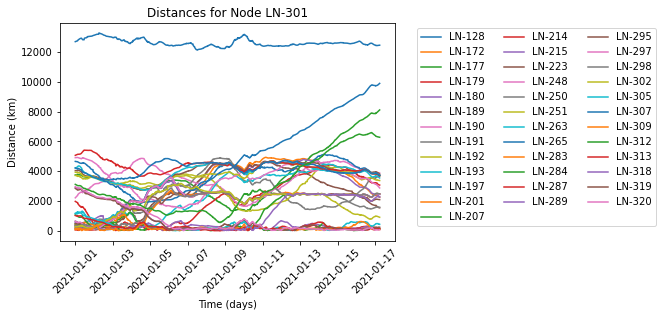

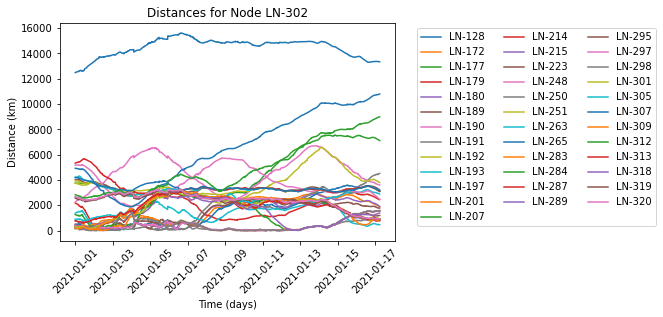

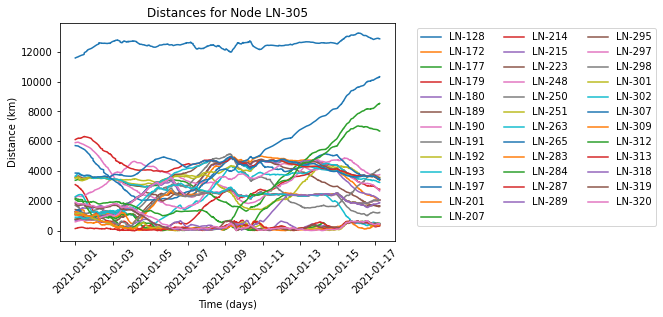

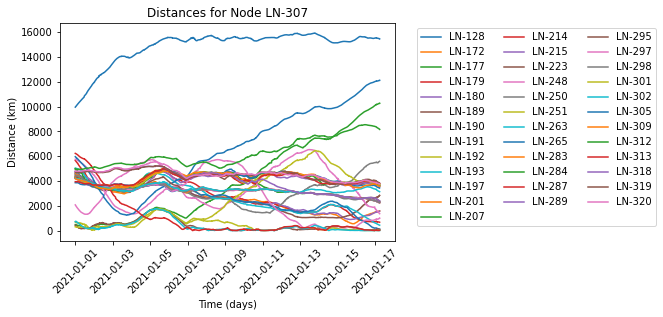

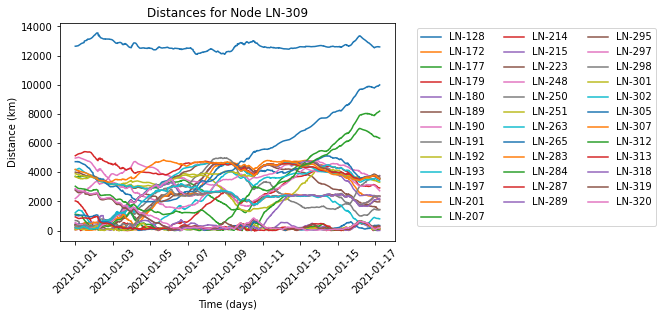

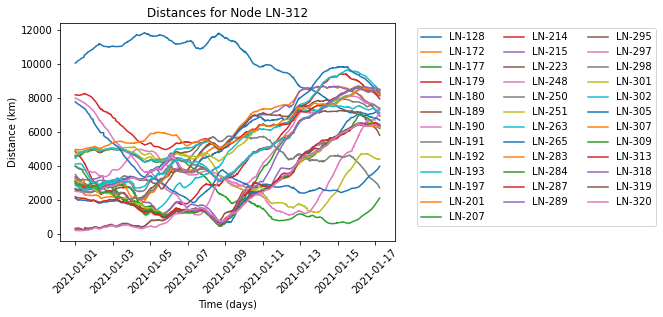

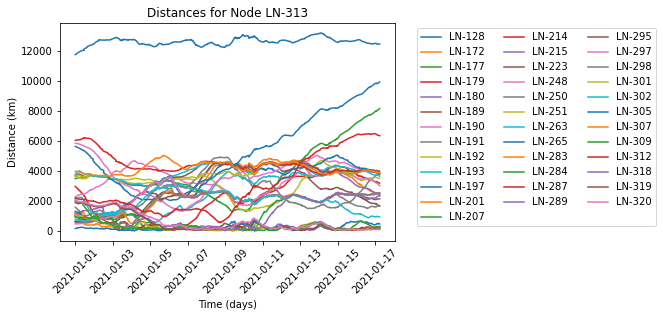

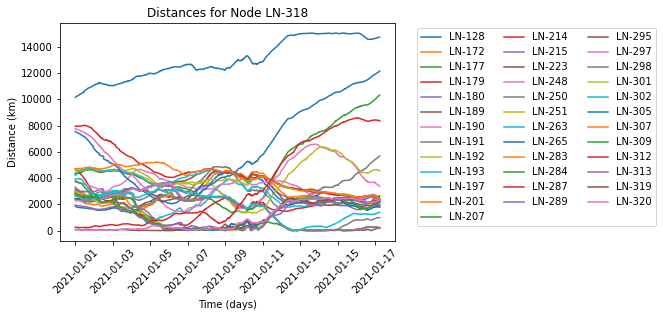

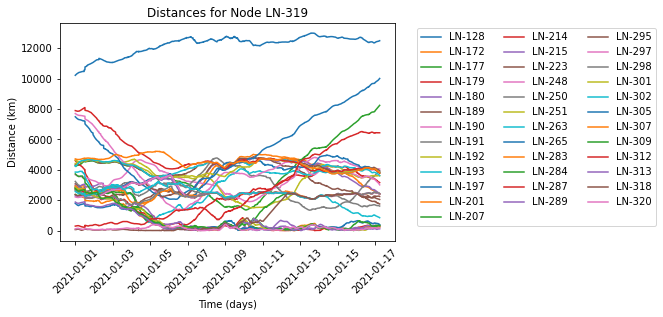

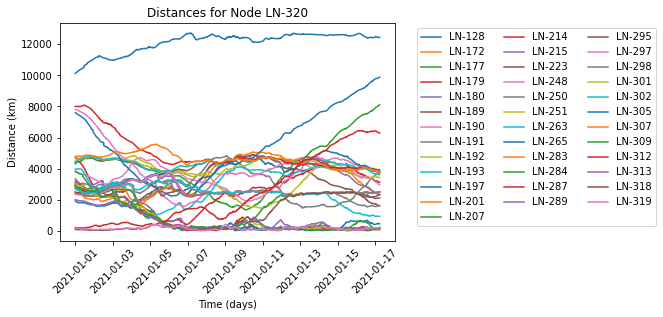

In [30]:
for row in range(0, dist.shape[1]): 
    #figure settings 
    fname = 'Node %s.png' % (flight_ids[row])
    fig_title = 'Distances for Node %s' % (flight_ids[row])
    
    fig, ax = plt.subplots()
    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Distance (km)')
    ax.set_title(fig_title)
    
    #loop through columns and plot 
    temp = dist[:, row, :]

    for column in range(0, dist.shape[2]):
        #check if on diagonal
        if np.any(temp[:, column]):
            ax.plot(x_axis, temp[:, column]/1e3, label = flight_ids[column])
        else:
            continue
    
    plt.legend(bbox_to_anchor=(1.05, 1.0), ncol = 3, loc='upper left')
    plt.xticks(rotation=45)
    plt.savefig(fname, dpi = 300, bbox_inches='tight')

# Network Data 

### Import 1 hour of Network Data


In [31]:
# Get data file names
df_net = pd.read_csv('link_reports-20210101-00.csv')

In [32]:
#remove whitespace in dataframe 
cols = df_net.columns
df_net[cols] = df_net[cols].apply(lambda x: x.str.strip() if x.dtype == "object" else x)

In [33]:
#check for any NaN values to remove
df_net.isnull().values.any()

False

### Split into two datasets based on center frequencies

In [34]:
df_70G = df_net[df_net[' band_profile_id'] == '70G-420w']
df_80G = df_net[df_net[' band_profile_id'] == '80G-420w']

## Data Rate vs. Receive Power
<p>Look for threshold between rx power and data rate. Then we can calculate rx power and set data rates between links</p>

In [35]:
df_70G_rx= df_70G[[" power_at_receiver_output_dbw", " data_rate_Mbps"]]
df_80G_rx= df_80G[[" power_at_receiver_output_dbw", " data_rate_Mbps"]]

data_rates = df_70G_rx[' data_rate_Mbps'].unique().tolist()
print(data_rates)

[987.0, 588.0, 195.0, 390.0, 98.0, 48.0]


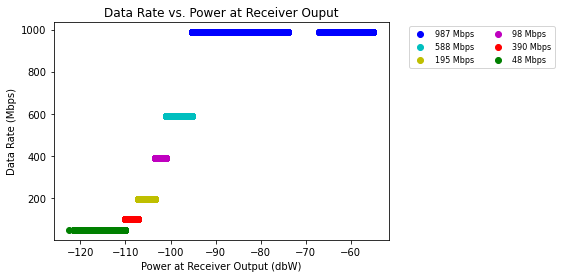

In [36]:
#scatter plot -- 70G
plt.figure()
plt.xlabel('Power at Receiver Output (dbW)')
plt.ylabel('Data Rate (Mbps)')
plt.title('Data Rate vs. Power at Receiver Ouput')

colors = ['b', 'c', 'y', 'm', 'r', 'g']
i = 0

for rate in data_rates:
    temp = df_70G_rx[df_70G_rx[' data_rate_Mbps'] == rate]
    plt.scatter(temp[' power_at_receiver_output_dbw'], temp[' data_rate_Mbps'], color=colors[i])
    i += 1

plt.legend(('987 Mbps', '588 Mbps', '195 Mbps', '98 Mbps', '390 Mbps', '48 Mbps'),
           scatterpoints=1,
           bbox_to_anchor=(1.05, 1.0), 
           loc='upper left',
           ncol=2,
           fontsize=8)

plt.savefig('Data Rate vs Power at Rx Output 70G.png', dpi = 300, bbox_inches = 'tight')
plt.show()

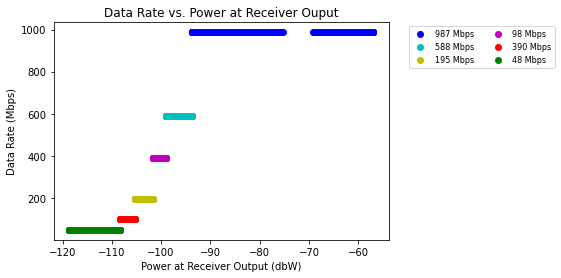

In [37]:
#scatter plot -- 80G
plt.figure()
plt.xlabel('Power at Receiver Output (dbW)')
plt.ylabel('Data Rate (Mbps)')
plt.title('Data Rate vs. Power at Receiver Ouput')

colors = ['b', 'c', 'y', 'm', 'r', 'g']
i = 0

for rate in data_rates:
    temp = df_80G_rx[df_80G_rx[' data_rate_Mbps'] == rate]
    plt.scatter(temp[' power_at_receiver_output_dbw'], temp[' data_rate_Mbps'], color=colors[i])
    i += 1

plt.legend(('987 Mbps', '588 Mbps', '195 Mbps', '98 Mbps', '390 Mbps', '48 Mbps'),
           scatterpoints=1,
           bbox_to_anchor=(1.05, 1.0), 
           loc='upper left',
           ncol=2,
           fontsize=8)

plt.savefig('Data Rate vs Power at Rx Output 80G.png', dpi = 300, bbox_inches = 'tight')
plt.show()

<p>Too much overlap between rx power and data rates</p> 

## Data Rate vs. Link Margin

In [38]:
df_70G_lm = df_70G[[" link_margin_db", " data_rate_Mbps"]]
df_80G_lm = df_80G[[" link_margin_db", " data_rate_Mbps"]]

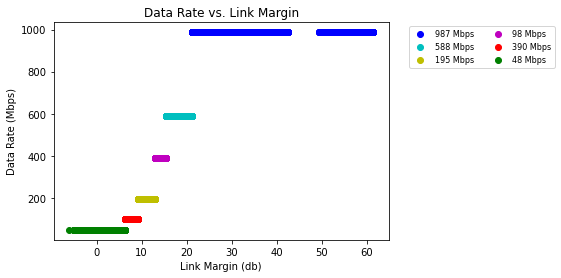

In [39]:
#scatter plot -- 70G
plt.figure()
plt.xlabel('Link Margin (db)')
plt.ylabel('Data Rate (Mbps)')
plt.title('Data Rate vs. Link Margin')

colors = ['b', 'c', 'y', 'm', 'r', 'g']
i = 0

for rate in data_rates:
    temp = df_70G_lm[df_70G_lm[' data_rate_Mbps'] == rate]
    plt.scatter(temp[' link_margin_db'], temp[' data_rate_Mbps'], color=colors[i])
    i += 1

plt.legend(('987 Mbps', '588 Mbps', '195 Mbps', '98 Mbps', '390 Mbps', '48 Mbps'),
           scatterpoints=1,
           bbox_to_anchor=(1.05, 1.0), 
           loc='upper left',
           ncol=2,
           fontsize=8)

plt.savefig('Data Rate vs Link Margin 70G.png', dpi = 300, bbox_inches = 'tight')
plt.show()

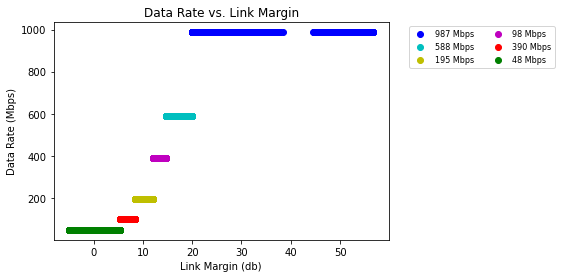

In [40]:
#scatter plot -- 80G
plt.figure()
plt.xlabel('Link Margin (db)')
plt.ylabel('Data Rate (Mbps)')
plt.title('Data Rate vs. Link Margin')

colors = ['b', 'c', 'y', 'm', 'r', 'g']
i = 0

for rate in data_rates:
    temp = df_80G_lm[df_80G_lm[' data_rate_Mbps'] == rate]
    plt.scatter(temp[' link_margin_db'], temp[' data_rate_Mbps'], color=colors[i])
    i += 1

plt.legend(('987 Mbps', '588 Mbps', '195 Mbps', '98 Mbps', '390 Mbps', '48 Mbps'),
           scatterpoints=1,
           bbox_to_anchor=(1.05, 1.0), 
           loc='upper left',
           ncol=2,
           fontsize=8)

plt.savefig('Data Rate vs Link Margin 80G.png', dpi = 300, bbox_inches = 'tight')
plt.show()

<p>Still have the same overlapping issue. </p>

## Link Margin vs. Rx Power
<p>Filter on data rate. Plot Rx power on the x-axis and Link Margin on the y-axis. From this you will see a range of Rx power for which Link Margin is >= 5dB. Let’s say that range is [-120, -108]dBW. Now filter on the next data rate, eg, 98Mbps. Again, plot Link Margin vs Rx power and identify the range of Rx power for which Link Margin is >= 5dB. In the best case, this range is [-108,-105] or something similar. Then it’s clear that for Rx power in [-120,-108] the selected data rate is 48Mbps and for Rx power in [-108,-105] the selected data rate is 98Mbps. If the “best case” doesn’t happen, and eg, the range of Rx power for which Link Margin is >= 5dB is [-110,-105]. Then in that case, we will say that for Rx power in [-120,-110] the data rate is 48Mbps and for Rx power in [-110,-105] the data rate is 98Mbps. And so on. </p>

<p>The end result should be two tables mapping rx power to data rate based on center frequency.</p>

In [41]:
df1 = df_net[[" link_margin_db", " power_at_receiver_output_dbw", " data_rate_Mbps", " accessibility", " band_profile_id"]] 

In [42]:
#look at link margin >= 5dB
df1 = df1[df1[' accessibility'] == 'EXISTS']

#arrays for storing start/end of ranges
dr_70G_rx_min = []
dr_70G_rx_max = []

dr_70G_lm_min = []
dr_70G_lm_max = []

dr_80G_rx_min = []
dr_80G_rx_max = []

dr_80G_lm_min = []
dr_80G_lm_max = []

In [43]:
dr_987 = df1[df1[' data_rate_Mbps'] == data_rates[0]]
dr_588 = df1[df1[' data_rate_Mbps'] == data_rates[1]]
dr_195 = df1[df1[' data_rate_Mbps'] == data_rates[2]]
dr_390 = df1[df1[' data_rate_Mbps'] == data_rates[3]]
dr_98 = df1[df1[' data_rate_Mbps'] == data_rates[4]]
dr_48= df1[df1[' data_rate_Mbps'] == data_rates[5]]

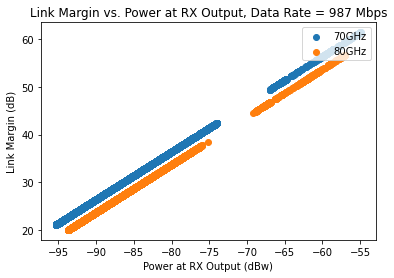

In [44]:
#plot as described above 
plt.figure()
plt.xlabel('Power at RX Output (dBw)')
plt.ylabel('Link Margin (dB)')
plt.title('Link Margin vs. Power at RX Output, Data Rate = 987 Mbps')

x1 = dr_987[dr_987[' band_profile_id'] == '70G-420w'][' power_at_receiver_output_dbw']
y1 = dr_987[dr_987[' band_profile_id'] == '70G-420w'][' link_margin_db']

x2 = dr_987[dr_987[' band_profile_id'] == '80G-420w'][' power_at_receiver_output_dbw']
y2 = dr_987[dr_987[' band_profile_id'] == '80G-420w'][' link_margin_db']

plt.scatter(x1, y1, label = '70GHz')
plt.scatter(x2, y2, label = '80GHz')
plt.legend(loc = 'upper right')
plt.show()

dr_70G_rx_min.append(dr_987[dr_987[' band_profile_id'] == '70G-420w'][' power_at_receiver_output_dbw'].min())
dr_70G_rx_max.append(dr_987[dr_987[' band_profile_id'] == '70G-420w'][' power_at_receiver_output_dbw'].max())

dr_80G_rx_min.append(dr_987[dr_987[' band_profile_id'] == '80G-420w'][' power_at_receiver_output_dbw'].min())
dr_80G_rx_max.append(dr_987[dr_987[' band_profile_id'] == '80G-420w'][' power_at_receiver_output_dbw'].max())

dr_70G_lm_min.append(dr_987[dr_987[' band_profile_id'] == '70G-420w'][' link_margin_db'].min())
dr_70G_lm_max.append(dr_987[dr_987[' band_profile_id'] == '70G-420w'][' link_margin_db'].max())

dr_80G_lm_min.append(dr_987[dr_987[' band_profile_id'] == '80G-420w'][' link_margin_db'].min())
dr_80G_lm_max.append(dr_987[dr_987[' band_profile_id'] == '80G-420w'][' link_margin_db'].max())

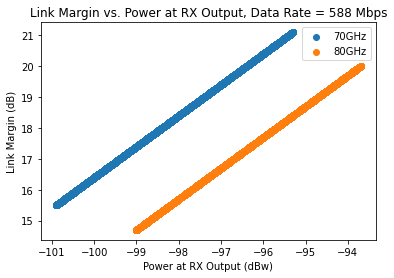

In [45]:
#plot as described above 
plt.figure()
plt.xlabel('Power at RX Output (dBw)')
plt.ylabel('Link Margin (dB)')
plt.title('Link Margin vs. Power at RX Output, Data Rate = 588 Mbps')

x1 = dr_588[dr_588[' band_profile_id'] == '70G-420w'][' power_at_receiver_output_dbw']
y1 = dr_588[dr_588[' band_profile_id'] == '70G-420w'][' link_margin_db']

x2 = dr_588[dr_588[' band_profile_id'] == '80G-420w'][' power_at_receiver_output_dbw']
y2 = dr_588[dr_588[' band_profile_id'] == '80G-420w'][' link_margin_db']

plt.scatter(x1, y1, label = '70GHz')
plt.scatter(x2, y2, label = '80GHz')
plt.legend(loc = 'upper right')
plt.show()

dr_70G_rx_min.append(dr_588[dr_588[' band_profile_id'] == '70G-420w'][' power_at_receiver_output_dbw'].min())
dr_70G_rx_max.append(dr_588[dr_588[' band_profile_id'] == '70G-420w'][' power_at_receiver_output_dbw'].max())

dr_80G_rx_min.append(dr_588[dr_588[' band_profile_id'] == '80G-420w'][' power_at_receiver_output_dbw'].min())
dr_80G_rx_max.append(dr_588[dr_588[' band_profile_id'] == '80G-420w'][' power_at_receiver_output_dbw'].max())

dr_70G_lm_min.append(dr_588[dr_588[' band_profile_id'] == '70G-420w'][' link_margin_db'].min())
dr_70G_lm_max.append(dr_588[dr_588[' band_profile_id'] == '70G-420w'][' link_margin_db'].max())

dr_80G_lm_min.append(dr_588[dr_588[' band_profile_id'] == '80G-420w'][' link_margin_db'].min())
dr_80G_lm_max.append(dr_588[dr_588[' band_profile_id'] == '80G-420w'][' link_margin_db'].max())

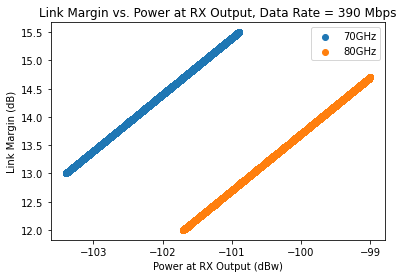

In [46]:
#plot as described above 
plt.figure()
plt.xlabel('Power at RX Output (dBw)')
plt.ylabel('Link Margin (dB)')
plt.title('Link Margin vs. Power at RX Output, Data Rate = 390 Mbps')

x1 = dr_390[dr_390[' band_profile_id'] == '70G-420w'][' power_at_receiver_output_dbw']
y1 = dr_390[dr_390[' band_profile_id'] == '70G-420w'][' link_margin_db']

x2 = dr_390[dr_390[' band_profile_id'] == '80G-420w'][' power_at_receiver_output_dbw']
y2 = dr_390[dr_390[' band_profile_id'] == '80G-420w'][' link_margin_db']

plt.scatter(x1, y1, label = '70GHz')
plt.scatter(x2, y2, label = '80GHz')
plt.legend(loc = 'upper right')
plt.show()

dr_70G_rx_min.append(dr_390[dr_390[' band_profile_id'] == '70G-420w'][' power_at_receiver_output_dbw'].min())
dr_70G_rx_max.append(dr_390[dr_390[' band_profile_id'] == '70G-420w'][' power_at_receiver_output_dbw'].max())

dr_80G_rx_min.append(dr_390[dr_390[' band_profile_id'] == '80G-420w'][' power_at_receiver_output_dbw'].min())
dr_80G_rx_max.append(dr_390[dr_390[' band_profile_id'] == '80G-420w'][' power_at_receiver_output_dbw'].max())

dr_70G_lm_min.append(dr_390[dr_390[' band_profile_id'] == '70G-420w'][' link_margin_db'].min())
dr_70G_lm_max.append(dr_390[dr_390[' band_profile_id'] == '70G-420w'][' link_margin_db'].max())

dr_80G_lm_min.append(dr_390[dr_390[' band_profile_id'] == '80G-420w'][' link_margin_db'].min())
dr_80G_lm_max.append(dr_390[dr_390[' band_profile_id'] == '80G-420w'][' link_margin_db'].max())

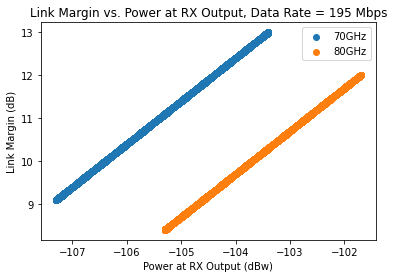

In [47]:
#plot as described above 
plt.figure()
plt.xlabel('Power at RX Output (dBw)')
plt.ylabel('Link Margin (dB)')
plt.title('Link Margin vs. Power at RX Output, Data Rate = 195 Mbps')

x1 = dr_195[dr_195[' band_profile_id'] == '70G-420w'][' power_at_receiver_output_dbw']
y1 = dr_195[dr_195[' band_profile_id'] == '70G-420w'][' link_margin_db']

x2 = dr_195[dr_195[' band_profile_id'] == '80G-420w'][' power_at_receiver_output_dbw']
y2 = dr_195[dr_195[' band_profile_id'] == '80G-420w'][' link_margin_db']

plt.scatter(x1, y1, label = '70GHz')
plt.scatter(x2, y2, label = '80GHz')
plt.legend(loc = 'upper right')
plt.show()

dr_70G_rx_min.append(dr_195[dr_195[' band_profile_id'] == '70G-420w'][' power_at_receiver_output_dbw'].min())
dr_70G_rx_max.append(dr_195[dr_195[' band_profile_id'] == '70G-420w'][' power_at_receiver_output_dbw'].max())

dr_80G_rx_min.append(dr_195[dr_195[' band_profile_id'] == '80G-420w'][' power_at_receiver_output_dbw'].min())
dr_80G_rx_max.append(dr_195[dr_195[' band_profile_id'] == '80G-420w'][' power_at_receiver_output_dbw'].max())

dr_70G_lm_min.append(dr_195[dr_195[' band_profile_id'] == '70G-420w'][' link_margin_db'].min())
dr_70G_lm_max.append(dr_195[dr_195[' band_profile_id'] == '70G-420w'][' link_margin_db'].max())

dr_80G_lm_min.append(dr_195[dr_195[' band_profile_id'] == '80G-420w'][' link_margin_db'].min())
dr_80G_lm_max.append(dr_195[dr_195[' band_profile_id'] == '80G-420w'][' link_margin_db'].max())

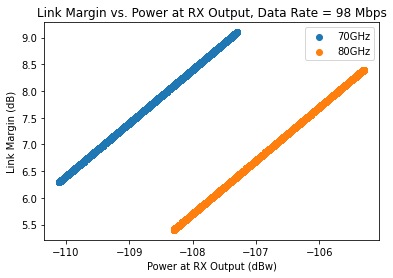

In [48]:
#plot as described above 
plt.figure()
plt.xlabel('Power at RX Output (dBw)')
plt.ylabel('Link Margin (dB)')
plt.title('Link Margin vs. Power at RX Output, Data Rate = 98 Mbps')

x1 = dr_98[dr_98[' band_profile_id'] == '70G-420w'][' power_at_receiver_output_dbw']
y1 = dr_98[dr_98[' band_profile_id'] == '70G-420w'][' link_margin_db']

x2 = dr_98[dr_98[' band_profile_id'] == '80G-420w'][' power_at_receiver_output_dbw']
y2 = dr_98[dr_98[' band_profile_id'] == '80G-420w'][' link_margin_db']

plt.scatter(x1, y1, label = '70GHz')
plt.scatter(x2, y2, label = '80GHz')
plt.legend(loc = 'upper right')
plt.show()

dr_70G_rx_min.append(dr_98[dr_98[' band_profile_id'] == '70G-420w'][' power_at_receiver_output_dbw'].min())
dr_70G_rx_max.append(dr_98[dr_98[' band_profile_id'] == '70G-420w'][' power_at_receiver_output_dbw'].max())

dr_80G_rx_min.append(dr_98[dr_98[' band_profile_id'] == '80G-420w'][' power_at_receiver_output_dbw'].min())
dr_80G_rx_max.append(dr_98[dr_98[' band_profile_id'] == '80G-420w'][' power_at_receiver_output_dbw'].max())

dr_70G_lm_min.append(dr_98[dr_98[' band_profile_id'] == '70G-420w'][' link_margin_db'].min())
dr_70G_lm_max.append(dr_98[dr_98[' band_profile_id'] == '70G-420w'][' link_margin_db'].max())

dr_80G_lm_min.append(dr_98[dr_98[' band_profile_id'] == '80G-420w'][' link_margin_db'].min())
dr_80G_lm_max.append(dr_98[dr_98[' band_profile_id'] == '80G-420w'][' link_margin_db'].max())

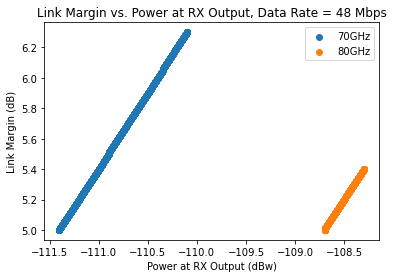

In [49]:
#plot as described above 
plt.figure()
plt.xlabel('Power at RX Output (dBw)')
plt.ylabel('Link Margin (dB)')
plt.title('Link Margin vs. Power at RX Output, Data Rate = 48 Mbps')

x1 = dr_48[dr_48[' band_profile_id'] == '70G-420w'][' power_at_receiver_output_dbw']
y1 = dr_48[dr_48[' band_profile_id'] == '70G-420w'][' link_margin_db']

x2 = dr_48[dr_48[' band_profile_id'] == '80G-420w'][' power_at_receiver_output_dbw']
y2 = dr_48[dr_48[' band_profile_id'] == '80G-420w'][' link_margin_db']

plt.scatter(x1, y1, label = '70GHz')
plt.scatter(x2, y2, label = '80GHz')
plt.legend(loc = 'upper right')
plt.show()

dr_70G_rx_min.append(dr_48[dr_48[' band_profile_id'] == '70G-420w'][' power_at_receiver_output_dbw'].min())
dr_70G_rx_max.append(dr_48[dr_48[' band_profile_id'] == '70G-420w'][' power_at_receiver_output_dbw'].max())

dr_80G_rx_min.append(dr_48[dr_48[' band_profile_id'] == '80G-420w'][' power_at_receiver_output_dbw'].min())
dr_80G_rx_max.append(dr_48[dr_48[' band_profile_id'] == '80G-420w'][' power_at_receiver_output_dbw'].max())

dr_70G_lm_min.append(dr_48[dr_48[' band_profile_id'] == '70G-420w'][' link_margin_db'].min())
dr_70G_lm_max.append(dr_48[dr_48[' band_profile_id'] == '70G-420w'][' link_margin_db'].max())

dr_80G_lm_min.append(dr_48[dr_48[' band_profile_id'] == '80G-420w'][' link_margin_db'].min())
dr_80G_lm_max.append(dr_48[dr_48[' band_profile_id'] == '80G-420w'][' link_margin_db'].max())

Plot the min/max of rx power and link margin on a line plot to visualize boundaries

In [50]:
pairs_rx_70 = list(zip(dr_70G_rx_min, dr_70G_rx_max))
pairs_rx_80 = list(zip(dr_80G_rx_min, dr_80G_rx_max))

pairs_lm_70 = list(zip(dr_70G_lm_min, dr_70G_lm_max))
pairs_lm_80 = list(zip(dr_80G_lm_min, dr_80G_lm_max))

In [55]:
print(pairs_rx_70)

[(-95.3, -54.95), (-100.9, -95.3), (-103.4, -100.9), (-107.3, -103.4), (-110.1, -107.3), (-111.4, -110.1)]


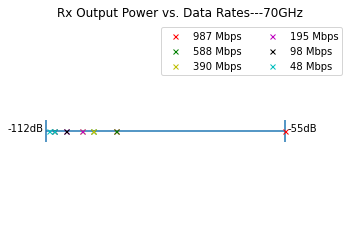

In [51]:
# set up the figure
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlim(-120,-40)
ax.set_ylim(0,10)

# draw lines
xmin = -112
xmax = -55
y = 5
height = 1

plt.hlines(y, xmin, xmax)
plt.vlines(xmin, y - height / 2., y + height / 2.)
plt.vlines(xmax, y - height / 2., y + height / 2.)

# draw a point on the line
markers = ['rx', 'gx', 'yx', 'mx', 'kx', 'cx']
mfc_colors = ['r', 'g', 'y', 'm', 'k', 'c']
labels = ['987 Mbps', '588 Mbps', '390 Mbps', '195 Mbps', '98 Mbps', '48 Mbps']
i = 0

for pair in pairs_rx_70: 
    plt.plot(pair[0], y, markers[i], ms = 5, mfc = mfc_colors[i], label = labels[i])
    plt.plot(pair[1], y, markers[i], ms = 5, mfc = mfc_colors[i])
    i += 1

# add numbers
plt.text(xmin - 0.7, y, '-112dB', horizontalalignment='right')
plt.text(xmax + 0.7, y, '-55dB', horizontalalignment='left')

plt.title('Rx Output Power vs. Data Rates---70GHz')
plt.legend(loc='upper right', ncol=2)

plt.axis('off')
plt.show()

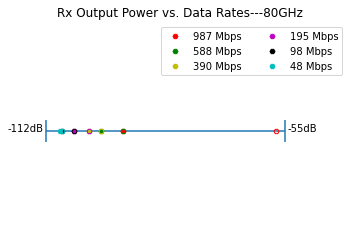

In [58]:
# set up the figure
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlim(-120,-40)
ax.set_ylim(0,10)

# draw lines
xmin = -112
xmax = -55
y = 5
height = 1

plt.hlines(y, xmin, xmax)
plt.vlines(xmin, y - height / 2., y + height / 2.)
plt.vlines(xmax, y - height / 2., y + height / 2.)

# draw a point on the line
markers = ['rH', 'gH', 'yH', 'mH', 'kH', 'cH']
mfc_colors = ['r', 'g', 'y', 'm', 'k', 'c']
labels = ['987 Mbps', '588 Mbps', '390 Mbps', '195 Mbps', '98 Mbps', '48 Mbps']
i = 0

for pair in pairs_rx_80: 
    plt.plot(pair[0], y, markers[i], ms = 5, mfc = mfc_colors[i], label = labels[i], fillstyle='full')
    plt.plot(pair[1], y, markers[i], ms = 5, mfc = mfc_colors[i], fillstyle= 'none')
    i += 1

# add numbers
plt.text(xmin - 0.7, y, '-112dB', horizontalalignment='right')
plt.text(xmax + 0.7, y, '-55dB', horizontalalignment='left')

plt.title('Rx Output Power vs. Data Rates---80GHz')
plt.legend(loc='upper right', ncol=2)

plt.axis('off')
plt.show()

In [ ]:
# set up the figure
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlim(0,63)
ax.set_ylim(0,10)

# draw lines
xmin = 5
xmax = 61.45
y = 5
height = 1

plt.hlines(y, xmin, xmax)
plt.vlines(xmin, y - height / 2., y + height / 2.)
plt.vlines(xmax, y - height / 2., y + height / 2.)

# draw a point on the line
markers = ['rx', 'gx', 'yx', 'mx', 'kx', 'cx']
mfc_colors = ['r', 'g', 'y', 'm', 'k', 'c']
labels = ['987 Mbps', '588 Mbps', '390 Mbps', '195 Mbps', '98 Mbps', '48 Mbps']
i = 0

for pair in pairs_lm_70: 
    plt.plot(pair[0], y, markers[i], ms = 5, mfc = mfc_colors[i], label = labels[i])
    plt.plot(pair[1], y, markers[i], ms = 5, mfc = mfc_colors[i])
    i += 1

# add numbers
plt.text(xmin - 0.7, y, '0 dB', horizontalalignment='right')
plt.text(xmax + 0.7, y, '63 dB', horizontalalignment='left')

plt.title('Link Margin vs. Data Rates---70GHz')
plt.legend(loc='upper right', ncol=2)

plt.axis('off')
plt.show()

In [ ]:
# set up the figure
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlim(0,63)
ax.set_ylim(0,10)

# draw lines
xmin = 5
xmax = 61.45
y = 5
height = 1

plt.hlines(y, xmin, xmax)
plt.vlines(xmin, y - height / 2., y + height / 2.)
plt.vlines(xmax, y - height / 2., y + height / 2.)

# draw a point on the line
markers = ['rx', 'gx', 'yx', 'mx', 'kx', 'cx']
labels = ['987 Mbps', '588 Mbps', '390 Mbps', '195 Mbps', '98 Mbps', '48 Mbps']
i = 0

for pair in pairs_lm_80: 
    plt.plot(pair[0], y, markers[i], ms = 5, mfc = 'k', label = labels[i])
    plt.plot(pair[1], y, markers[i], ms = 5, mfc = 'k')
    i += 1

# add numbers
plt.text(xmin - 0.7, y, '0 dB', horizontalalignment='right')
plt.text(xmax + 0.7, y, '63 dB', horizontalalignment='left')

plt.title('Link Margin vs. Data Rates---80GHz')
plt.legend(loc='upper right', ncol=2)

plt.axis('off')
plt.show()

#### Define Rx Power  to Data Rate Mapping 

In [ ]:
print(pairs_rx_70)
print(pairs_rx_80)

##### Mapping for 70 GHz Fc 

[-111.4, -110.1) -> 48Mbps <br>
[-110.1, -107.3) -> 98Mbps <br>
[-107.3, -103.4) -> 195Mbps <br>
[-103.4, -100.9) -> 390Mbps <br>
[-100.9, -95.3) -> 588Mbps <br>
[95.3, -54.95 (Inf)] -> 987Mbps

##### Mapping for 80 GHz Fc

[-108.7, -108.3) -> 48Mbps <br>
[-108.3, -105.3) -> 98Mbps <br>
[-105.3, -101.7) -> 195Mbps <br>
[-101.7, -99.0) -> 390Mbps <br>
[-99.0, -93.7) -> 588Mbps <br>
[-93.7, -56.97 (Inf)] -> 987Mbps

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


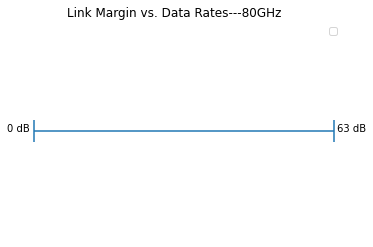

In [54]:
# set up the figure
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlim(0,63)
ax.set_ylim(0,10)

# draw lines
xmin = 5
xmax = 61.45
y = 5
height = 1

plt.hlines(y, xmin, xmax)
plt.vlines(xmin, y - height / 2., y + height / 2.)
plt.vlines(xmax, y - height / 2., y + height / 2.)

# add numbers
plt.text(xmin - 0.7, y, '0 dB', horizontalalignment='right')
plt.text(xmax + 0.7, y, '63 dB', horizontalalignment='left')

plt.title('Link Margin vs. Data Rates---80GHz')
plt.legend(loc='upper right', ncol=2)

plt.axis('off')
plt.show()

# Explore Relationships Between Data Rates and Other Variables

## Data Rate vs. Link Margin vs. Received Ouput Power
<p> is there a clearer relationship between the three</p> 

In [ ]:
df1 = df_net[[" link_margin_db", " power_at_receiver_output_dbw", " data_rate_Mbps"]]
data_rates = df_net[' data_rate_Mbps'].unique().tolist()

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('Power at Rx Ouput (dBw)')
ax.set_ylabel('Link Margin (dB)')
ax.set_zlabel('Data Rate (Mbps)')

i=0
for rate in data_rates:
    temp = df1[df1[' data_rate_Mbps'] == rate]
    ax.scatter(temp[' power_at_receiver_output_dbw'], temp[' link_margin_db'], temp[' data_rate_Mbps'], c=colors[i])
    i+=1



plt.show()

## Data Rate vs. Cummulative Propogation Loss 
<p> sanity check </p>

In [ ]:
df1 = df_net[[" cummulative_propagation_loss_db", " data_rate_Mbps"]]
data_rates = df_net[' data_rate_Mbps'].unique().tolist()

In [ ]:
#scatter plot
plt.figure()
plt.xlabel('Cummulative Propagation Loss (db)')
plt.ylabel('Data Rate (Mbps)')
plt.title('Data Rate vs. Cummulative Propogation Loss ')

colors = ['b', 'c', 'y', 'm', 'r', 'g']
i = 0

for rate in data_rates:
    temp = df1[df1[' data_rate_Mbps'] == rate]
    plt.scatter(temp[' cummulative_propagation_loss_db'], temp[' data_rate_Mbps'], color=colors[i])
    i += 1

plt.legend(('987 Mbps', '588 Mbps', '195 Mbps', '98 Mbps', '390 Mbps', '48 Mbps'),
           scatterpoints=1,
           bbox_to_anchor=(1.05, 1.0), 
           loc='upper left',
           ncol=2,
           fontsize=8)

plt.savefig('Data Rate vs CumPropLoss.png', dpi = 300, bbox_inches = 'tight')
plt.show()

## Data Rate vs. EIRP
<p> another check sanity check, I don't expect there to be any relationship here <p> 

In [ ]:
df1 = df_net[[" effective_isotropic_radiated_power_dbw", " data_rate_Mbps"]]
data_rates = df_net[' data_rate_Mbps'].unique().tolist()

In [ ]:
#scatter plot
plt.figure()
plt.xlabel('Effective Isotropic Radiated Power (dBw)')
plt.ylabel('Data Rate (Mbps)')
plt.title('Data Rate vs. EIRP')

colors = ['b', 'c', 'y', 'm', 'r', 'g']
i = 0

for rate in data_rates:
    temp = df1[df1[' data_rate_Mbps'] == rate]
    plt.scatter(temp[' effective_isotropic_radiated_power_dbw'], temp[' data_rate_Mbps'], color=colors[i])
    i += 1

plt.legend(('987 Mbps', '588 Mbps', '195 Mbps', '98 Mbps', '390 Mbps', '48 Mbps'),
           scatterpoints=1,
           bbox_to_anchor=(1.05, 1.0), 
           loc='upper left',
           ncol=2,
           fontsize=8)

plt.savefig('Data Rate vs EIRP.png', dpi = 300, bbox_inches = 'tight')
plt.show()

## Data Rate vs. Transmit Power
<p>I don't expect there to be a correlation here, but just a sanity check. </p>

In [ ]:
df1 = df_net[[" transmit_power_watts", " data_rate_Mbps"]]
data_rates = df_net[' data_rate_Mbps'].unique().tolist()

In [ ]:
#scatter plot
plt.figure()
plt.xlabel('Transmit Power (W)')
plt.ylabel('Data Rate (Mbps)')
plt.title('Data Rate vs. Tx Power')

colors = ['b', 'c', 'y', 'm', 'r', 'g']
i = 0

for rate in data_rates:
    temp = df1[df1[' data_rate_Mbps'] == rate]
    plt.scatter(temp[' transmit_power_watts'], temp[' data_rate_Mbps'], color=colors[i])
    i += 1

plt.legend(('987 Mbps', '588 Mbps', '195 Mbps', '98 Mbps', '390 Mbps', '48 Mbps'),
           scatterpoints=1,
           bbox_to_anchor=(1.05, 1.0), 
           loc='upper left',
           ncol=2,
           fontsize=8)

plt.savefig('Data Rate vs TxPwr.png', dpi = 300, bbox_inches = 'tight')
plt.show()

## Data Rate vs. Center Frequency

another sanity check

In [ ]:
df1 = df_net[[" channel_center_freq_Ghz", " data_rate_Mbps"]]
data_rates = df_net[' data_rate_Mbps'].unique().tolist()

In [ ]:
#scatter plot
plt.figure()
plt.xlabel('Channel Center Frequency (GHz)')
plt.ylabel('Data Rate (Mbps)')
plt.title('Data Rate vs. Center Frequency')

colors = ['b', 'c', 'y', 'm', 'r', 'g']
i = 0

for rate in data_rates:
    temp = df1[df1[' data_rate_Mbps'] == rate]
    plt.scatter(temp[' channel_center_freq_Ghz'], temp[' data_rate_Mbps'], color=colors[i])
    i += 1

plt.legend(('987 Mbps', '588 Mbps', '195 Mbps', '98 Mbps', '390 Mbps', '48 Mbps'),
           scatterpoints=1,
           bbox_to_anchor=(1.05, 1.0), 
           loc='upper left',
           ncol=2,
           fontsize=8)

plt.savefig('Data Rate vs Fc.png', dpi = 300, bbox_inches = 'tight')
plt.show()